In [1]:
import os
import torch
import matplotlib.pyplot as plt
from utils.resnet_rand import resnet18, SparsifyFiltersLayer, SparsifyKernelGroups
from typing import Any, Type, Union
import numpy as np
import torch.nn as nn
import pickle

/home/zsarwar/.conda/envs/cnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
ckpt = "model_best.pth.tar"
#model_path_1=  "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_600547deae5b3d506d5c0befd9134c77/Checkpoints"
model_path_1 = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_814e4c261078e7110bf94f724cd2187e/Checkpoints"
ckpt_path_1 = os.path.join(model_path_1, ckpt)
plot_path_1 = model_path_1.replace("Checkpoints", "Plots")
#model_path_2 = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_2ec2f01d64d67544298a8ba4e5303489/Checkpoints"
model_path_2="/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_43528ed29912dd1a3825f30bea8e4ba8/Checkpoints"
ckpt = "model_best.pth.tar"
ckpt_path_2 = os.path.join(model_path_2, ckpt)
plot_path_2 = model_path_2.replace("Checkpoints", "Plots")

In [35]:
scale_factor=4
sparsefilter="SparsifyKernelGroups"
# Select sparseblock here
sparseblock : Type[Union[SparsifyFiltersLayer, SparsifyKernelGroups]]

if sparsefilter == 'SparsifyFiltersLayer':
    sparseblock = SparsifyFiltersLayer
elif sparsefilter == 'SparsifyKernelGroups':
    sparseblock = SparsifyKernelGroups


In [36]:
loc="cpu"
ckpt = torch.load(ckpt_path_1, map_location=loc)
model_1 = resnet18(sparsefilter=sparseblock,scale_factor=scale_factor)
model_1.fc = torch.nn.Linear(512, 10)
model_1.load_state_dict(ckpt['state_dict'])
model_1 = model_1.to(loc)

In [5]:
scale_factor=2
sparsefilter="SparsifyKernelGroups"
# Select sparseblock here
sparseblock : Type[Union[SparsifyFiltersLayer, SparsifyKernelGroups]]

if sparsefilter == 'SparsifyFiltersLayer':
    sparseblock = SparsifyFiltersLayer
elif sparsefilter == 'SparsifyKernelGroups':
    sparseblock = SparsifyKernelGroups


In [6]:
loc="cpu"
ckpt = torch.load(ckpt_path_2, map_location=loc)
model_2 = resnet18(sparsefilter=sparseblock,scale_factor=scale_factor)
model_2.fc = torch.nn.Linear(512, 10)
model_2.load_state_dict(ckpt['state_dict'])
model_2 = model_2.to(loc)

# Visualize filters

In [20]:
selected_kernel_indices = [80,81]
selected_kernels = model_2.layer1[0].conv1.weight[selected_kernel_indices]
selected_filter_indices = list(range(0, 64, 3))
group_1 = selected_kernels[0::2, selected_filter_indices]
group_2 = selected_kernels[1::2, selected_filter_indices]

In [21]:
selected_kernel_groups = torch.concatenate((group_1, group_2), dim=1)
filter_nums = selected_kernel_groups.shape[1] // 2

In [23]:
plot_path_1

'/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_814e4c261078e7110bf94f724cd2187e/Plots'

In [ ]:
base_config = f"kernel_visualization_scale-factor_{scale_factor}_"
selected_kernel_indices = [0,1, 20,21, 40,41, 60,61, 80,81]

# Iterate over kernels
for name, param in model_2.named_modules():
    if "conv" in name and "layer" in name:
        kernel_vectors = param.weight.flatten(1)
        selected_kernels = model_2.layer1[0].conv1.weight[selected_kernel_indices]
        selected_filter_indices = list(range(0, 64, 3))
        group_1 = selected_kernels[0::2, selected_filter_indices]
        group_2 = selected_kernels[1::2, selected_filter_indices]

        selected_kernel_groups = torch.concatenate((group_1, group_2), dim=1)
        filter_nums = selected_kernel_groups.shape[1] // 2

        for f in range(selected_kernel_groups.shape[0]):
            # Init figure
            fig, axes = plt.subplots(2, filter_nums, figsize=(100, 10))
            axes = axes.flatten()
            filter_group_idx = selected_kernel_indices[f*2]
            kernel_config = base_config +  f"_{name}_filter-group-{filter_group_idx}.jpg"
            image_path = os.path.join(plot_path_1, kernel_config)
            fig.suptitle(f"Kernel Group {filter_group_idx}", fontsize=60)
            for ch, ax in enumerate(axes):
                curr_filter = selected_kernel_groups[f][ch]
                # Normalize
                f_min, f_max = curr_filter.min(), curr_filter.max()
                curr_filter = (curr_filter - f_min) / (f_max - f_min)
                curr_filter = curr_filter.detach().numpy()
                ax.imshow(curr_filter)
                ax.axis('off')
                filter_num_idx = ch % filter_nums
                ax.set_title(selected_filter_indices[filter_num_idx], fontsize=35)
            plt.savefig(image_path, bbox_inches='tight')
            

# Get distribution between filter groups across layers

# Regularized Model

In [7]:
MSE = nn.MSELoss(reduction='none')
MSE_reduc = nn.MSELoss(reduction='sum')
kernel_distances_1 = []
mean_weights = []
for name, param in model_1.named_modules():
    if "conv" in name and "layer" in name:
        kernel_vectors = param.weight.flatten(1)
        group_1 = kernel_vectors[0::2]
        group_2 = kernel_vectors[1::2]
        l2_dist = (torch.sqrt(MSE(group_1, group_2).sum(dim=1))).mean()
        mean_weights.append(group_2.mean())
        kernel_distances_1.append(l2_dist.detach().cpu().item())

        

# Unregularized Model

In [8]:
MSE = nn.MSELoss(reduction='none')
kernel_distances_2 = []
for name, param in model_2.named_modules():
    if "conv" in name and "layer" in name:
        kernel_vectors = param.weight.flatten(1)
        #print(kernel_vectors.shape)
        group_1 = kernel_vectors[0::2]
        group_2 = kernel_vectors[1::2]
        l2_dist = (torch.sqrt(MSE(group_1, group_2).sum(dim=1))).mean()
        kernel_distances_2.append(l2_dist.detach().cpu().item())

        

# Plots

In [9]:
kernel_distances_1 = [round(d, 6) for d in kernel_distances_1]
mean_weights = [round(d.item(), 6) for d in mean_weights]
kernel_distances_2 = [round(d, 6) for d in kernel_distances_2]

In [10]:
x_axis = np.arange(1,len(kernel_distances_1)+1)

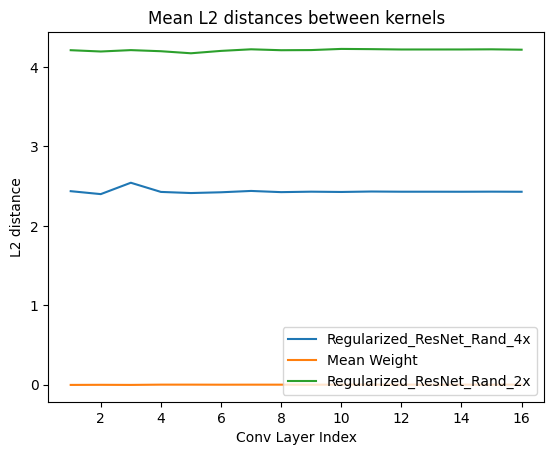

In [16]:
config = "Reg_Unreg_l2_comparison.jpg"
plt.title("Mean L2 distances between kernels")
plt.plot(x_axis, kernel_distances_1, label="Regularized_ResNet_Rand_4x")
plt.plot(x_axis, mean_weights, label="Mean Weight")
plt.plot(x_axis, kernel_distances_2, label="Regularized_ResNet_Rand_2x")
plt.legend(loc='lower right')
plt.xlabel("Conv Layer Index")
plt.ylabel("L2 distance")

plot_path = os.path.join(plot_path_1, config)
plt.savefig(plot_path, bbox_inches='tight')

In [17]:
plot_path

'/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_814e4c261078e7110bf94f724cd2187e/Plots/Reg_Unreg_l2_comparison.jpg'

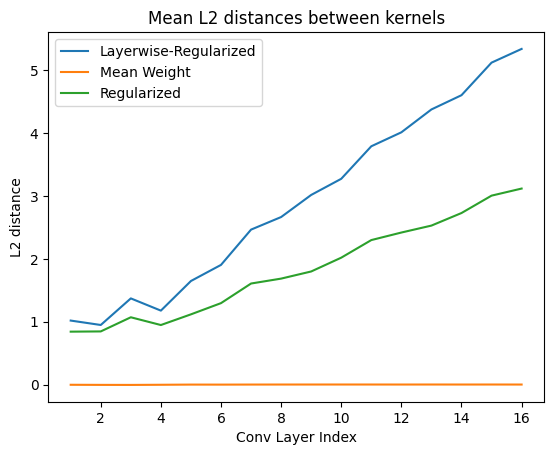

In [126]:
config = "Reg_Unreg_l2_comparison.jpg"
plt.title("Mean L2 distances between kernels")
plt.plot(x_axis, kernel_distances_1, label="Layerwise-Regularized")
plt.plot(x_axis, mean_weights, label="Mean Weight")
plt.plot(x_axis, kernel_distances_2, label="Regularized")
plt.legend()
plt.xlabel("Conv Layer Index")
plt.ylabel("L2 distance")

plot_path = os.path.join(plot_path_1, config)
#plt.savefig(plot_path, bbox_inches='tight')

In [14]:
plot_path

'/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_2ec2f01d64d67544298a8ba4e5303489/Plots/Reg_Unreg_l2_comparison.jpg'

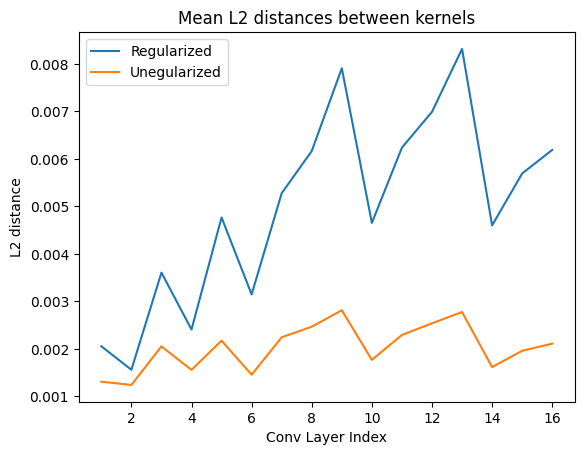

In [14]:
config = "Reg_Unreg_l2_comparison.jpg"
plt.title("Mean L2 distances between kernels")
plt.plot(x_axis, kernel_distances_1, label="Regularized")
plt.plot(x_axis, kernel_distances_2, label="Unegularized")
plt.legend()
plt.xlabel("Conv Layer Index")
plt.ylabel("L2 distance")

plot_path = os.path.join(plot_path_1, config)
#plt.savefig(plot_path, bbox_inches='tight')

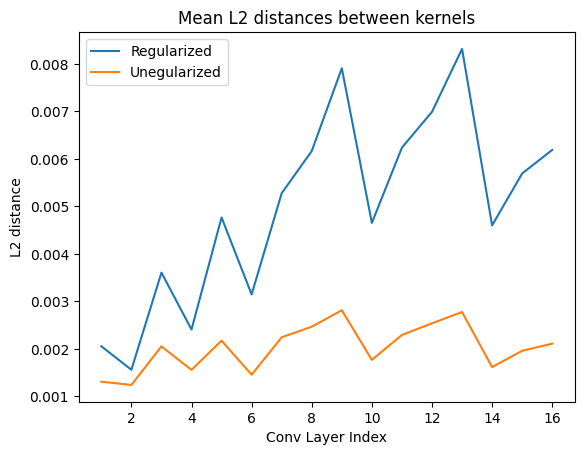

In [15]:
config = "Reg_Unreg_l2_comparison.jpg"
plt.title("Mean L2 distances between kernels")
plt.plot(x_axis, kernel_distances_1, label="Regularized")
plt.plot(x_axis, kernel_distances_2, label="Unegularized")
plt.legend()
plt.xlabel("Conv Layer Index")
plt.ylabel("L2 distance")

plot_path = os.path.join(plot_path_1, config)
#plt.savefig(plot_path, bbox_inches='tight')

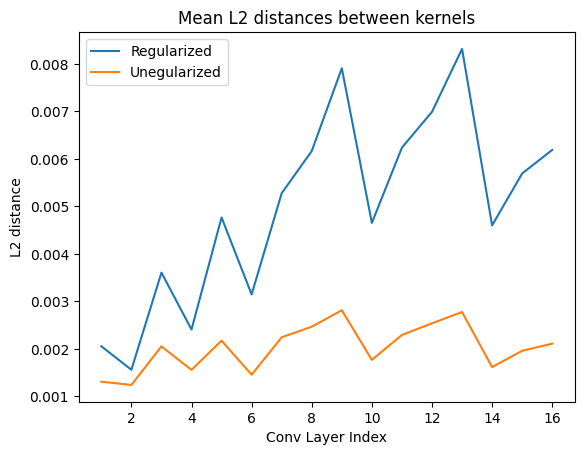

In [16]:
config = "Reg_Unreg_l2_comparison.jpg"
plt.title("Mean L2 distances between kernels")
plt.plot(x_axis, kernel_distances_1, label="Regularized")
plt.plot(x_axis, kernel_distances_2, label="Unegularized")
plt.legend()
plt.xlabel("Conv Layer Index")
plt.ylabel("L2 distance")

plot_path = os.path.join(plot_path_1, config)
plt.savefig(plot_path, bbox_inches='tight')

# Visualize Feature Maps

In [38]:

def plot_side_by_side(maps, layer, save_path=None):
    images = torch.concatenate(maps, dim=0)
    fig, axes = plt.subplots(len(maps), maps[0].shape[0], figsize=(100, 30))
    fig.suptitle(layer, fontsize=50)
    #axes[1].set_title(titles[1])
    axes = axes.flatten()
    for ch, ax in enumerate(axes):
        if ch < len(axes) // len(maps):
            ax.set_title(ch, fontsize=50)
            # title
        ax.imshow(images[ch])
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')



In [32]:

#2x
#path_0 = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_43528ed29912dd1a3825f30bea8e4ba8/ReLUs/ConvFeatures_CW_test_adversarial_2500_detector-type-Regular_integrated-False_c-1.0_d-0.0_0:2.pth"
#path_1 = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_43528ed29912dd1a3825f30bea8e4ba8/ReLUs/ConvFeatures_CW_test_adversarial_2500_detector-type-Regular_integrated-False_c-1.0_d-0.0_1:2.pth"

#4x
paths = ["/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_814e4c261078e7110bf94f724cd2187e/ReLUs/ConvFeatures_CW_test_adversarial_2500_detector-type-Regular_integrated-False_c-1.0_d-0.0_0:4.pth",
        "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_814e4c261078e7110bf94f724cd2187e/ReLUs/ConvFeatures_CW_test_adversarial_2500_detector-type-Regular_integrated-False_c-1.0_d-0.0_1:4.pth",
        "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_814e4c261078e7110bf94f724cd2187e/ReLUs/ConvFeatures_CW_test_adversarial_2500_detector-type-Regular_integrated-False_c-1.0_d-0.0_2:4.pth",
        "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_814e4c261078e7110bf94f724cd2187e/ReLUs/ConvFeatures_CW_test_adversarial_2500_detector-type-Regular_integrated-False_c-1.0_d-0.0_3:4.pth"]


all_feature_maps = []

for path in paths:
    with open(path, 'rb') as in_file:
        t_map = pickle.load(in_file)
        all_feature_maps.append(t_map)



In [33]:
all_layers = ['layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.1.conv1', 'layer3.1.conv2', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.1.conv1', 'layer4.1.conv2']
#base_path = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_43528ed29912dd1a3825f30bea8e4ba8/Visualizations"
base_path = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_814e4c261078e7110bf94f724cd2187e/Visualizations"

In [40]:
start=0
end=20

for layer in all_layers:
    maps =[f_map[layer][0, start:end, :, :] for f_map in all_feature_maps]
    save_config = f"{layer}_{start}_{end}.jpg"
    save_path = os.path.join(base_path, save_config)

    plot_side_by_side(maps, layer, save_path)